In [30]:
import pandas as pd
import geopandas as gpd
import shapely.geometry
import mercantile
from tqdm import tqdm
import os
import tempfile
import fiona
import matplotlib.pyplot as plt
import contextily as ctx

In [31]:
# Area of Interest (AOI) Geometry
area_of_interest_geometry = {
    "coordinates": [
        [
            [12.0924, 49.0140],  # Lower left corner
            [12.0924, 49.0220],  # Upper left corner
            [12.1014, 49.0220],  # Upper right corner
            [12.1014, 49.0140],  # Lower right corner
            [12.0924, 49.0140],  # Back to start
        ]
    ],
    "type": "Polygon",
}

# Convert AOI Geometry to Shapely Geometry for easier manipulation
shapely_geometry = shapely.geometry.shape(area_of_interest_geometry)

# Get the bounding box coordinates of the Shapely Geometry
min_longitude, min_latitude, max_longitude, max_latitude = shapely_geometry.bounds

# Output filename for the GeoJSON file
output_geojson_filename = "example_building_footprints.geojson"

In [32]:
# Set to hold unique QuadKeys
unique_quad_keys = set()

# Iterate over each tile in the specified bounding box and zoom level
for tile in list(mercantile.tiles(min_longitude, min_latitude, max_longitude, max_latitude, zooms=9)):
    # Convert each tile to a QuadKey and add it to the set
    unique_quad_keys.add(int(mercantile.quadkey(tile)))

# Convert the set of QuadKeys to a list
quad_key_list = list(unique_quad_keys)

print(f"The input area spans {len(quad_key_list)} tiles: {quad_key_list}")

The input area spans 1 tiles: [120212223]


In [33]:
# Load the dataset links CSV file into a DataFrame
dataset_links = pd.read_csv(
    "https://minedbuildings.blob.core.windows.net/global-buildings/dataset-links.csv"
)

# Initialize an index and a list for the combined rows
combined_row_index = 0
combined_rows_list = []

# Create a temporary directory to store the downloaded GeoJSON files
with tempfile.TemporaryDirectory() as temporary_directory:
    temporary_filenames = []

    # Download the GeoJSON files for each tile that intersects the input geometry
    for quad_key in tqdm(quad_key_list):
        # Get the rows in the dataset links DataFrame that match the current QuadKey
        matching_rows = dataset_links[dataset_links["QuadKey"] == quad_key]
        if matching_rows.shape[0] == 1:
            # Get the URL of the GeoJSON file for the current QuadKey
            geojson_url = matching_rows.iloc[0]["Url"]

            # Load the GeoJSON file into a DataFrame
            geojson_dataframe = pd.read_json(geojson_url, lines=True)
            # Convert the geometry column to Shapely Geometry objects
            geojson_dataframe["geometry"] = geojson_dataframe["geometry"].apply(shapely.geometry.shape)

            # Convert the DataFrame to a GeoDataFrame
            geodataframe = gpd.GeoDataFrame(geojson_dataframe, crs=4326)

            temporary_filename = os.path.join(temporary_directory, f"{quad_key}.geojson")
            temporary_filenames.append(temporary_filename)

            # Save the GeoDataFrame to a GeoJSON file if it doesn't already exist
            if not os.path.exists(temporary_filename):
                geodataframe.to_file(temporary_filename, driver="GeoJSON")
            
        elif matching_rows.shape[0] > 1:
            raise ValueError(f"Multiple rows found for QuadKey: {quad_key}")
        else:
            raise ValueError(f"QuadKey not found in dataset: {quad_key}")

    # Merge the GeoJSON files into a single file
    for temporary_filename in temporary_filenames:
        with fiona.open(temporary_filename, "r") as geojson_file:
            for row in tqdm(geojson_file):
                row = dict(row)
                row_geometry = shapely.geometry.shape(row["geometry"])

                if shapely_geometry.contains(row_geometry):
                    if "id" in row:
                        del row["id"]
                    row["properties"] = {"id": combined_row_index}
                    combined_row_index += 1
                    combined_rows_list.append(row)

100%|██████████| 187563/187563 [00:40<00:00, 4682.39it/s]


In [34]:
# Define the schema for the output GeoJSON file
geojson_schema = {"geometry": "Polygon", "properties": {"id": "int"}}

# Write the combined rows to the GeoJSON file
with fiona.open(output_geojson_filename, "w", driver="GeoJSON", crs="EPSG:4326", schema=geojson_schema) as geojson_file:
    geojson_file.writerecords(combined_rows_list)

Current CRS: epsg:4326
Error transforming CRS: x, y, z, and time must be same size
Error adding basemap: The inferred zoom level of 34 is not valid for the current tile provider. This can indicate that the extent of your figure is wrong (e.g. too small extent, or in the wrong coordinate reference system)


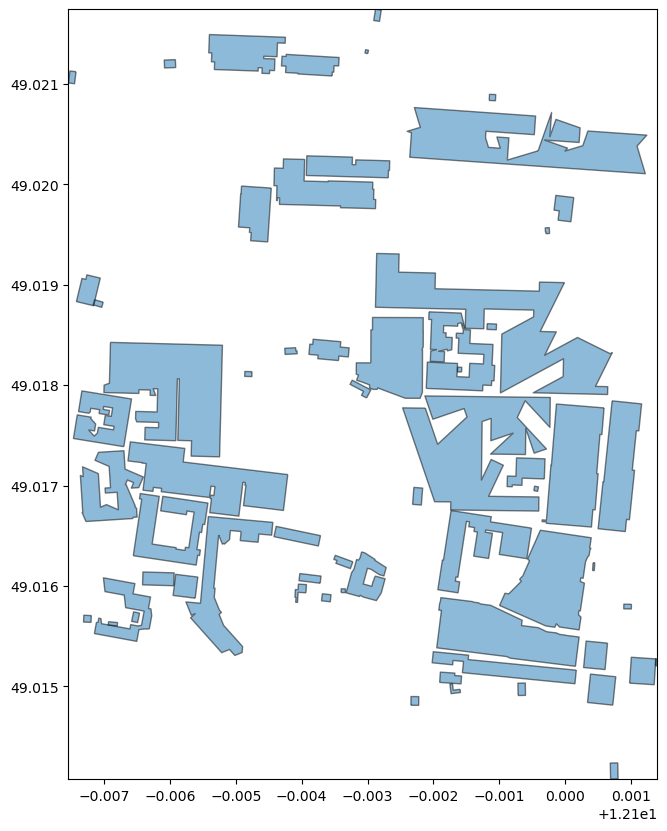

In [35]:
# Load the GeoJSON file into a GeoDataFrame
gdf = gpd.read_file("example_building_footprints.geojson")

# Check if the GeoDataFrame has a CRS
if gdf.crs is None:
    print("GeoDataFrame doesn't have a CRS. Please set it before transforming.")
else:
    print(f"Current CRS: {gdf.crs}")

# Check for invalid geometries
if not all(gdf.is_valid):
    print("Invalid geometries detected. Removing...")
    gdf = gdf[gdf.is_valid]

# Ensure the GeoDataFrame is using the correct CRS for contextily
try:
    gdf = gdf.to_crs(epsg=3857)
except Exception as e:
    print(f"Error transforming CRS: {e}")

# Plot the building footprints
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

# Manually set the extent of the plot to the bounds of the GeoDataFrame
ax.set_xlim(gdf.total_bounds[0], gdf.total_bounds[2])
ax.set_ylim(gdf.total_bounds[1], gdf.total_bounds[3])

# Add a satellite basemap
try:
    ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery)
except Exception as e:
    print(f"Error adding basemap: {e}")

plt.show()